# Faster and Better Machine Learning

### Special Codes for Collaboratory (code)
#### Provides access to google drive
This code provides access to your google drive folder so files  can be saved

In [ ]:
# if running on collaboratory set = True
collaboratory = True

if collaboratory:
    from google.colab import drive
    drive.mount('/content/drive')
else: 
    print('Running on local systems, if running on collaboratory please change above')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/My\ Drive

/content/drive/My Drive


In [ ]:
import os
if os.path.exists("./Faster-than-Faster-Better-than-Better-Machine-Learning-Electromechanical-Switching-in-Ferroelec"):
    pass
else:
    !git clone https://github.com/shuyuqin/Faster-than-Faster-Better-than-Better-Machine-Learning-Electromechanical-Switching-in-Ferroelec.git

In [ ]:
cd "/content/drive/My Drive/Faster-than-Faster-Better-than-Better-Machine-Learning-Electromechanical-Switching-in-Ferroelec"

/content/drive/My Drive/Faster-than-Faster-Better-than-Better-Machine-Learning-Electromechanical-Switching-in-Ferroelec


In [ ]:
!git pull

Already up to date.


In [ ]:
cd faster_code

/content/drive/My Drive/Faster-than-Faster-Better-than-Better-Machine-Learning-Electromechanical-Switching-in-Ferroelec/faster_code


# Implement and load the package

In [ ]:
%load_ext autoreload
%autoreload 2
import codes.util.core as core
import codes.util.file as file
import codes.util.machine_learning as ml
import codes.util.dictionary_learning as dl

In [ ]:
import tensorflow as tf
import numpy as np
from skimage import io
import string
import datetime
import tensorflow_probability as tfp
import sys
#sys.path.append('/content/pyNSID/')
#import pyNSID as nsid
import matplotlib.pyplot as plt
#import sidpy as sid
#import h5py
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from os.path import join as pjoin
from scipy import ndimage
import os
from numpy.random import seed
from tqdm import tqdm
from sklearn.decomposition import PCA, NMF, DictionaryLearning
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from matplotlib.ticker import FormatStrFormatter
from sklearn.decomposition import NMF
from scipy import io as ios
import os.path
from matplotlib import cm
from scipy.signal import savgol_filter as sg
from scipy import interpolate
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd

## Check the tensorflow version





In [ ]:
if (tf.__version__ != '2.3.0'):
  !pip install -U tensorflow==2.3.0

     |████████████████████████████████| 320.4MB 54kB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
     |████████████████████████████████| 460kB 60.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


## Set the printing format

In [ ]:
printing = {'PNG':True,
            'EPS':False, 
           'dpi': 300}

# Abstract
$\beta$-Vae  Compared with 

# Compare dictionary learning and lstm neural network using 'Nala' data

## Generate the training data

In [ ]:
# Sets random seed for reproducibility
np.random.seed(2)

# generates random parameters for spectra
random_values = np.random.uniform(size=(500000,3))

# Loads dog image
image = io.imread('./nala.jpg')

# Crops dog image
image = image[200:1900, 100:1500]/255

In [ ]:
%%time
random_data = core.generate_data(random_values)
dog_data = core.generate_data(image.reshape(-1,3))

CPU times: user 5min 9s, sys: 211 ms, total: 5min 9s
Wall time: 5min 10s


## Pretrain the data

In [ ]:
scaler = core.global_scaler()

scaled_data = scaler.fit_transform(random_data)

#print(scaler.mean)
#print(scaler.std)
scaled_dog = scaler.transform(dog_data)



## Run a kmeans analysis

In [ ]:
nclusters = 3

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(scaled_data)
kmeans_linear = KMeans(n_clusters=nclusters, random_state=0).fit(scaled_data)

In [ ]:
clusters_2nd = kmeans.labels_
centroids_2nd = kmeans.cluster_centers_

#### Reformat the kmeans results to use as the initial guess for Dictionary learning
labels = clusters_2nd
comp_init = np.zeros_like(centroids_2nd)
lm_init = np.zeros((len(labels),nclusters))
for i in range(nclusters):
    u = np.zeros_like(labels)
    u[labels==i] = 1
    lm_init[:,i] = u
    comp_init[i] = centroids_2nd[i]

## Run dictionary learning

In [ ]:
%%time
dictonary_model = DictionaryLearning(n_components=3,code_init=lm_init, dict_init = comp_init, 
                           n_jobs=1, max_iter=1000, transform_algorithm='lasso_lars', 
                           alpha=1, fit_algorithm='cd',positive_code=True, tol=1e-9)

dictonary_model.fit(scaled_data)

CPU times: user 10min 56s, sys: 3.72 s, total: 11min
Wall time: 10min 55s


## generate the prediction of the dl model

In [ ]:
%%time
dictionary_prediction = dictonary_model.transform(scaled_data)
dictionary_dog_prediction = dictonary_model.transform(scaled_dog)

CPU times: user 13min 34s, sys: 1.3 s, total: 13min 35s
Wall time: 13min 37s


In [ ]:
return_data_random = np.dot(dictionary_prediction, dictonary_model.components_)
return_data_dog = np.dot(dictionary_dog_prediction, dictonary_model.components_)

## generate the embedding map 

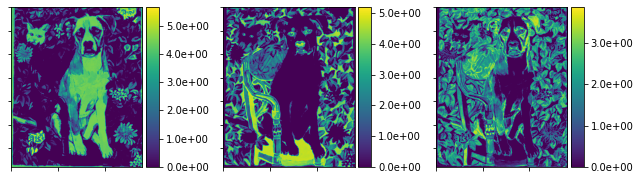

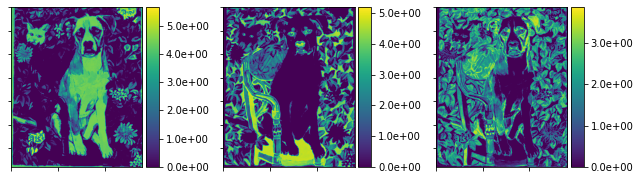

In [ ]:
core.embedding_maps(dictionary_dog_prediction, image)

## Generate LSTM model for training

In [ ]:
beta = 0

model_dnn = ml.model_builder(np.atleast_3d(scaled_data),embedding=16, 
              VAE=True, l1_norm_embedding=1e-3,coef=beta)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model_dnn.vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())



## Load the pretrained weights 

In [ ]:
model_dnn.vae.load_weights('./0.13_epochs_begin_2600+0199-0.06359.hdf5')

## generate the embedding map

In [ ]:
embedding = model_dnn.encoder_model.predict(np.atleast_3d(scaled_dog))

In [ ]:
core.embedding_maps(embedding[:,[10,11,14]], image, c_lim=[-4,4])

## generate the prediction of the nn model

In [ ]:
random_nn_out = model_dnn.vae.predict(np.atleast_3d(scaled_data)) 

## generate movie of the embedding result

In [ ]:
generator_dictionary_maker = core.generator(dictonary_model,scaled_dog, image)
generator_dictionary_maker.generator_images(folder = './dog_gen_test/', 
                                 number_of_loops=200)

In [ ]:
file.make_movie('dog_gen_movie',
          './dog_gen_test/',
          './dog_gen_test/',
          'png',
          5)

## Compare the results of two models

In [ ]:
fig, ax = core.layout_fig(16, mod=4, x=1.2)

ind = np.random.randint(0,scaled_data.shape[0],size=16)

ax=ax.ravel()

for i, ax in enumerate(ax):
    ax.plot(x, scaled_data[ind[i]], label='raw data')
    ax.plot(x, random_nn_out[ind[i]].squeeze(),'g--', label = 'Neural Network')
    ax.plot(x, return_data_random[ind[i]]
            ,'r--', label = 'Dictonary Learning')
    #ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    ax.set_ylabel('Magnitude (Arb. U.)')

    if i > 11:
      ax.set_xlabel('x value')
    
    if i == 3:
        ax.legend(bbox_to_anchor =(1.05, 1))
        
plt.tight_layout()

# Dictionary Learning for combination of piezoresponse and resonance data 
The dictionary learning is based on the result of the paper: Better, Faster, and Less Biased Machine Learning:
Electromechanical Switching in Ferroelectric Thin Films.The ORCID identification number(s) for the author(s) of this article
can be found under https://doi.org/10.1002/adma.202002425.


## Global parameters

In [ ]:
save_path = './'        #Where to save figures
global_n = 5           # Number of components in dictionary learning analysis
add_in_save = ''       # Add into the figure save name
global_alp = [1,6,12]  # Alpha values to try

path_to_data = './'

# Automatically generate a folder structure to save results
comp_folder = str(global_n)+'_comp/'
alp_folder = str(global_alp)+'_alp/'

if not os.path.exists(save_path+comp_folder+alp_folder):
    os.makedirs(save_path+comp_folder+alp_folder)

## import and clean the data

In [ ]:
# imports the raw band excitation data
imported = {'data': ios.matlab.loadmat(path_to_data+'Data.mat'),
            'validation_data': ios.matlab.loadmat(path_to_data+'loop_1.mat')}

# extracts the important information from the raw data
raw = {'voltage': imported['data']['Voltagedata_mixed'],
       'piezoresponse': imported['data']['Loopdata_mixed'],
       'amplitude': imported['data']['OutA2_mixed'],
       'phase': imported['data']['OutPhi2_mixed'],
       'resonance': imported['data']['Outw2_mixed'],
       'quality_factor': imported['data']['OutQ2_mixed'],
       'val_piezoresponse': imported['validation_data']['piezo_1'],
       'val_resonance': imported['validation_data']['resonance_loop_1'],
       #'pr_1': imported['data']['OutA1_mixed']*np.sin(np.deg2rad(imported['data']['OutPhi1_mixed'])),
       'pr_1': imported['validation_data']['piezo_1'],
       'res_1': imported['data']['Outw1_mixed'],
       'amp_1': imported['data']['OutA1_mixed'],
       'ph_1': imported['data']['OutPhi1_mixed'],
       'q_1': imported['data']['OutQ1_mixed'],}

In [ ]:
# These cleaning steps were also performed in [1,2]
dl.range_filter(raw['resonance'], [1300, 1340])          # "Hard limit" replace resonance values outside the specified range with NaN     
dl.range_filter(raw['val_resonance'], [1300, 1340])      # Same for the first cycle resonance
dl.clean_interpolate(raw['resonance'],'linear').reshape(-1, raw['resonance'].shape[2])    #Interpolate those NaNs

## Extract and Format

In [ ]:
# extract the second cycle data (amplitude, phase, resonance, and Q)
second_amp = np.reshape(raw['amplitude'],(3600,96))
second_ph = np.reshape(raw['phase'],(3600,96))
second_res = np.reshape(raw['resonance'],(3600,96))
second_q = np.reshape(raw['quality_factor'],(3600,96))

# Extract the provided "optimal rotation angle"
opt_ang = np.reshape(imported['data']['optrotang_mixed'],(3600))

# Resonstrcut the second cycle PR
second_ph = second_ph+np.mean(opt_ang)
second_pr = second_amp*np.cos(np.deg2rad(second_ph))

#Extract voltage data
v_cycle = imported['data']['VoltageDC_mixed'][:,0].squeeze()



In [ ]:
# Replace any infinte values in the amplitude/phase curves with NaN. NaNs can be ignored when taking the mean, infs can't.
second_amp[~np.isfinite(second_amp)] = np.nan
second_ph[~np.isfinite(second_ph)] = np.nan

# Get the mean maps for plotting later
sA_mean = np.nanmean(second_amp, axis=1)
sP_mean = np.nanmean(second_ph, axis=1)
sR_mean = np.nanmean(second_res, axis=1)
sQ_mean = np.nanmean(second_q, axis=1)
sPR_mean = np.nanmean(second_pr, axis=1)



In [ ]:
all_second = np.hstack([second_pr,second_res])       #Here we are interested in the piezoresponse and the resonance
num_vars = 2     # Thats two variables

#We have to account for infinite values (bad fits) in the piezoresponse
x, y = np.where(~np.isfinite(all_second))
all_second[x, y] = 0

#-------------Generate all of the various labels to use in the data frame
times = 96
all_vals = np.repeat('PR', times)
for var in ['Res']:
    varlist = np.repeat(var, times)
    all_vals = np.hstack([all_vals,varlist])

xvals = np.hstack([v_cycle,v_cycle])
chirps = np.tile(np.arange(times),num_vars)
inout = np.tile(np.full(times, 0),num_vars)
plotgroup = np.tile(np.full(times, 0),num_vars)
arrays =[all_vals,chirps,inout,plotgroup,xvals]

cols = pd.MultiIndex.from_tuples(list(zip(*arrays)), names=['Vars', 'ChirpNum','InOut','PlotGroup','xaxis'])
index = pd.Index(np.arange(3600).astype(int),name='Acq')
#---------------

# Create the dataframe
second_data = pd.DataFrame(all_second, columns=cols, index=index)

## Use Kmeans to highlight outliers

In [ ]:
res_mean = np.mean(second_data['Res'],axis=1)
pie_mean = np.mean(second_data['PR'],axis=1)

### Remove Mean and Scale PR

In [ ]:
scale = 3 # Constant to scale PR by such that resonance and PR have the same standard deviation

# For each row of data (i.e. spatial point), remove the mean of the row
second_data['Res'] = second_data['Res'].apply(lambda x: x-x.mean(), axis=1)
second_data['PR'] = second_data['PR'].apply(lambda x: x-x.mean(), axis=1)

#Scale piezoresponse
second_data['PR'] = second_data['PR']*scale*1e4

In [ ]:
# Run kmeans
var = ['Res']         # Variable to run
data = second_data    # Data to run
voltages = v_cycle    # x-axis data, i.e. voltages

orig_shape = [60,60]
nclusters = 8
voltages = data[var].columns.get_level_values('xaxis')

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(data[var])
clus_mean_removal = kmeans.labels_.reshape((orig_shape[0], orig_shape[1]))
cent_mean_removal = kmeans.cluster_centers_

### Run a final kmeans analysis

In [ ]:
vol = np.load('voltage.npy')

In [ ]:
stack_vars = ['PR','Res']
data_list = ['PR','Res']
data = all_second
voltages = v_cycle

orig_shape = [60,60]
nclusters = global_n

stacked_dataset = second_data

#kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(stacked_dataset.values[~flags,:])
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(stacked_dataset.values)
clusters_2nd = kmeans.labels_
centroids_2nd = kmeans.cluster_centers_

## Run Dictionary Learning

In [ ]:
# Lists to save all of the components/maps
comps = []
maps = []

voltages = v_cycle              #Voltage values
stacked_dataset = second_data  #The data to analyze

# For each alpah value listed above
for alp in global_alp:

    orig_shape = [60,60]       # Don't forget this is a 60,x60 grid
    sparsity = alp             # Alpha value for this iteration
    iterations = 10000         # Max number of iterations
    num_components = global_n  # Number of components to find

#    dataset_analysis = stacked_dataset.values[~flags,:]    # Remove the above "bad" points from consideration
    dataset_analysis = stacked_dataset.values
    #### Reformat the kmeans results to use as the initial guess for Dictionary learning
    labels = clusters_2nd
    comp_init = np.zeros_like(centroids_2nd)
    lm_init = np.zeros((len(labels),num_components))
    for i in range(num_components):
        u = np.zeros_like(labels)
        u[labels==i] = 1
        lm_init[:,i] = u
        comp_init[i] = centroids_2nd[i]
        
    # Set up dictionary learning model
    model = DictionaryLearning(n_components=num_components, code_init=lm_init, dict_init = comp_init, n_jobs=-1, max_iter=iterations, transform_algorithm='lasso_lars', alpha=sparsity, fit_algorithm='cd',positive_code=True, tol=1e-9)
    
    # Fit and get weight maps/ components
    DL_loading_maps = model.fit_transform(dataset_analysis)
    DL_components = model.components_

## Visualize the fit and transform of the model 

In [ ]:
core.embedding_maps(DL_loading_maps, np.zeros((60,60)), mod = 5)

In [ ]:
fig, ax = layout_fig(10, mod=5, x=1.2)

ax = ax.ravel()

for i, ax in enumerate(ax):
    
    if i < 5:
        ax.plot(voltages,DL_components[i][0:96])
        ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
        ax.set_ylabel('Piezoresponse (Arb. U.)')
        
    else: 
        ax.plot(vol,DL_components[i-5][96::])
        ax.set_ylabel('Resonance (Arb U)')
        ax.set_xlabel('Voltage (V)')
        #ax.set_ylim([1324.5,1325.5])
        
plt.tight_layout()

## Use the model generate the reconstraction data and unscale the data for comparision

In [ ]:
out_dl = np.dot(DL_loading_maps,DL_components)

In [ ]:
out_dl_unscale = np.copy(out_dl)
for i in range(out.shape[0]):
    out_dl_unscale[i,0:96] = out_dl_unscale[i,0:96]/(3*1e4)+pie_mean[i]
    out_dl_unscale[i,96:192] = out_dl_unscale[i,96:192]+res_mean[i]

# LSTM Neural Network Autoencoder for combination of piezoresponse and resonance data 




## load the pretrained data

In [ ]:
pie_data = np.load('pizoresponse.npy')
res_data = np.load('resonance.npy')
res_data = np.atleast_3d(res_data)
new_data = np.concatenate((pie_data,res_data),axis=2)

## Implement the model

## Set the training parameters 

In [ ]:
epochs=62000 
epoch_per_increase = 1000
iteration = (epochs//epoch_per_increase) + 1
iteration

## Train the model

## Load the pretrained weights

In [ ]:
nn_model = ml.model_builder_combine(np.atleast_3d(new_data),embedding=16, 
              VAE=True, l1_norm_embedding=1e-9,coef=0)

In [ ]:
nn_model.vae.load_weights('phase_shift_only0.0175_epochs_begin_6000+7000+0966-0.01752.hdf5')

## Or train the data from the beginning

In [ ]:
folder_ = core.make_folder('/content/drive/My Drive/papers/Faster_better_v2_Training/two_data_combined/piezoresponse+resonacnce')


In [ ]:
ml.Train(epochs,epoch_per_increase,0,0.0025,new_data,folder_)

## Generate the reconstraction data 

In [ ]:
nn_out = nn_model.vae.predict(np.atleast_3d(new_data)


## Unscale the data for comparision

In [ ]:
unscaled_pie = nn_out[:,:,0]*7.859902800847493e-05 -1.0487273116670697e-05
unscaled_res = nn_out[:,:,1]*3.1454182388943095+1324.800141637855

## plot the embedding channels

In [ ]:
embedding = nn_model.encoder_model.predict(np.atleast_3d(new_data))
image = np.zeros((60,60,3))
core.embedding_maps(embedding, image, mod=4)

## Generate the movie

In [ ]:
model = './deep_learning'
channels = [5,6,10,11,14]

In [ ]:
Gan = core.generator(model,new_data,np.zeros((60,60)),channels=channels)
Gan.generator_images(folder, graph_layout=[5,5], xvalues=vol)

# Compare results of two models

## Load the raw data 

In [ ]:
ori_pie = pie_data*7.859902800847493e-05 -1.0487273116670697e-05
ori_res = res_data*3.1454182388943095+1324.800141637855


## Plot the raw data, DL result and NN result

In [ ]:
fig, ax = core.layout_fig(10, mod=5, x=1.2)

ind = np.random.randint(0,3600,size=5)

ax=ax.ravel()

for i, ax in enumerate(ax):
    
    if i < 5:
#        ax.plot(voltages, orig_data[ind[i//2], 0:96])
        ax.plot(vol,ori_pie[ind[i]], label='raw data')
        ax.plot(vol,unscaled_pie[ind[i]],'g--', label = 'Neural Network')
        ax.plot(voltages,out_dl_unscale[ind[i],0:96],'r--', label = 'Dictonary Learning')
        ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
        ax.set_ylabel('Piezoresponse (Arb. U.)')
    else:
#        ax.plot(vol,orig_data[ind[i//2],96:192])
        ax.plot(vol,ori_res[ind[i-5]])
        ax.plot(vol,unscaled_res[ind[i-5]],'g--')
        ax.plot(vol,out_dl_unscale[ind[i-5],96:192],'r--')
        ax.set_ylabel('Resonance (KHz)')
        ax.set_xlabel('Voltage (V)')
    
    if i == 4:
        ax.legend(bbox_to_anchor =(1.05, 1))
        
plt.tight_layout()

file.savefig(f'./example_{ind}_maps', printing)